# Predicting MLB Slugging Percentage

### April 26, 2025

Import packages

In [142]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Load datasets

In [143]:
df = pd.read_csv('Data/stats.csv')

## Exploratory Data Analysis (EDA)

#### Introduction to Data

This data was downloaded from MLB's official statistics branch, Baseball Savant (https://baseballsavant.mlb.com/). This tool allows users to select certain seasons, qualifications, and which statistics you want to see. Some of the statistics included in this dataset are

* general hitting statistics like plate appearances and batting average
* bat tracking stastics like average bat speed
* exit velocity and launch angle

The data is from 2015 - 2024, and players with at least 50 plate appearances are included. Many players will have multiple entries since they play multiple seasons, but this should not matter when trying to predict slugging percentage.

In [144]:
print(df.shape)

(5336, 30)


In [145]:
df.columns

Index(['last_name, first_name', 'player_id', 'year', 'pa', 'home_run', 'walk',
       'k_percent', 'bb_percent', 'batting_avg', 'slg_percent',
       'on_base_percent', 'b_rbi', 'xba', 'xslg', 'woba', 'xwoba', 'xobp',
       'avg_swing_speed', 'fast_swing_rate', 'blasts_contact', 'blasts_swing',
       'squared_up_contact', 'squared_up_swing', 'exit_velocity_avg',
       'launch_angle_avg', 'sweet_spot_percent', 'barrel_batted_rate',
       'hard_hit_percent', 'whiff_percent', 'swing_percent'],
      dtype='object')

In [146]:
print(df.dtypes)

last_name, first_name     object
player_id                  int64
year                       int64
pa                         int64
home_run                   int64
walk                       int64
k_percent                float64
bb_percent               float64
batting_avg              float64
slg_percent              float64
on_base_percent          float64
b_rbi                      int64
xba                      float64
xslg                     float64
woba                     float64
xwoba                    float64
xobp                     float64
avg_swing_speed          float64
fast_swing_rate          float64
blasts_contact           float64
blasts_swing             float64
squared_up_contact       float64
squared_up_swing         float64
exit_velocity_avg        float64
launch_angle_avg         float64
sweet_spot_percent       float64
barrel_batted_rate       float64
hard_hit_percent         float64
whiff_percent            float64
swing_percent            float64
dtype: obj

#### Data Cleaning & Preprocessing

Let's first check for null or missing data.

In [147]:
df.isna().sum()

last_name, first_name       0
player_id                   0
year                        0
pa                          0
home_run                    0
walk                        0
k_percent                   0
bb_percent                  0
batting_avg                 0
slg_percent                 0
on_base_percent             0
b_rbi                       0
xba                         0
xslg                        0
woba                        0
xwoba                       0
xobp                        0
avg_swing_speed          4306
fast_swing_rate          4306
blasts_contact           4306
blasts_swing             4306
squared_up_contact       4306
squared_up_swing         4306
exit_velocity_avg           0
launch_angle_avg            0
sweet_spot_percent          0
barrel_batted_rate          0
hard_hit_percent            0
whiff_percent               0
swing_percent               0
dtype: int64

There are a number of missing values for a few of the statistics. This is due to which stats are tracked given the year. The entire dataset only back to 2015, however, certain advanced metrics related to bat tracking were not collected this entire time. The bat tracking metrics are only available starting from the second half of the 2023 season. Due to this, I will create multiple dataframes to separate the data containing these metrics from the rest, and compare how well the models work at the end to see how important these are for slugging percentage.

In [148]:
# Store data with bat tracking metrics
df_tracking = df[~df.isna().any(axis=1)]
df_tracking.isna().sum()

last_name, first_name    0
player_id                0
year                     0
pa                       0
home_run                 0
walk                     0
k_percent                0
bb_percent               0
batting_avg              0
slg_percent              0
on_base_percent          0
b_rbi                    0
xba                      0
xslg                     0
woba                     0
xwoba                    0
xobp                     0
avg_swing_speed          0
fast_swing_rate          0
blasts_contact           0
blasts_swing             0
squared_up_contact       0
squared_up_swing         0
exit_velocity_avg        0
launch_angle_avg         0
sweet_spot_percent       0
barrel_batted_rate       0
hard_hit_percent         0
whiff_percent            0
swing_percent            0
dtype: int64

The next concern to address is the number of plate appearances (pa), or the amount of at bats a player had that season.

In [149]:
df[['pa', 'batting_avg', 'home_run', 'slg_percent']].describe()

,pa,batting_avg,home_run,slg_percent
count,5336.000000,5336.000000,5336.000000,5336.000000
mean,314.392616,0.236105,9.978823,0.385226
std,200.266348,0.047529,9.737093,0.098708
min,50.000000,0.000000,0.000000,0.000000
25%,132.000000,0.211000,2.000000,0.329000
50%,274.000000,0.242000,7.000000,0.391000
75%,484.250000,0.267000,15.000000,0.448000
max,753.000000,0.400000,62.000000,0.755000


The MLB lists minimum qualifications that must be met for players to qualify for certain leaderboards. This prevents a player for example who only had 1 at bat the entire season and got a hit from leading the entire MLB with a 1.0 batting average. For hitters, this minimum amount is 3.1 PA's a game. There are a number of specifics to this calculation, such as when teams play one more or one fewer games, when players are active or not, as well as a specific rookie standard.

This is something we want ot think about before creating our models. Ensuring players have "enough" at bats in a season can help ensure the findings are statistacally relevant, and resistant to being swayed by outliers. Let's visualize the distribution of plate appearances to see if it might have a significant impact on our models.

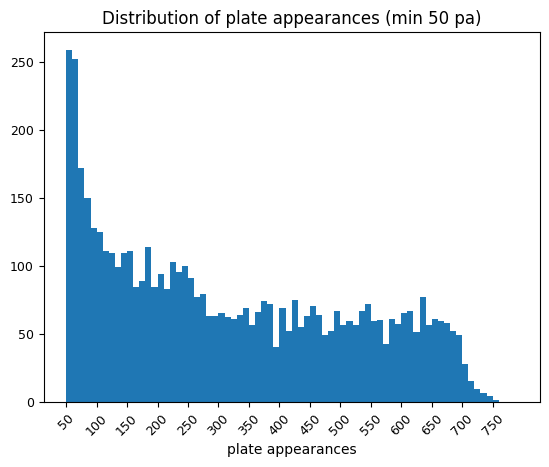

In [188]:
plt.hist(df['pa'], bins=range(50, 800, 10))
plt.xticks(range(50, 800, 50), rotation=45, fontsize=9)
plt.yticks(fontsize=9)
plt.title('Distribution of plate appearances (min 50 pa)')
plt.xlabel('plate appearances')
plt.show()

We can see the distribution is skewed right by a significant margin. Let's separate the data and see how the distribution looks. A boxplot can also be helpful to look for outliers and get an overview of general distribution.

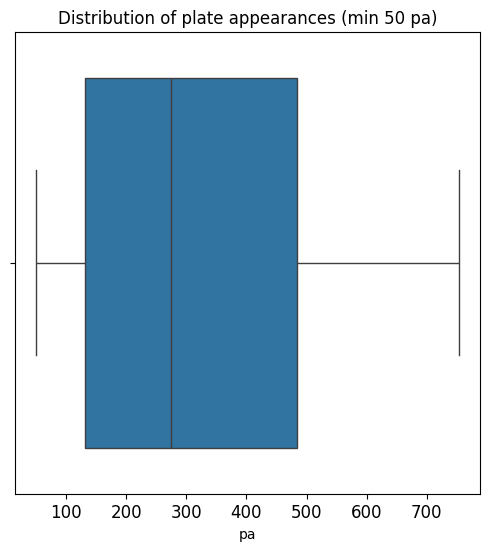

In [191]:
plt.figure(figsize=(6,6))
plt.title('Distribution of plate appearances (min 50 pa)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['pa'])
plt.show()

There are no outliers apparant from the boxplot, but we do see again that the data is skewed right by a large margin. We can make some quick calculations to find out exavtly how much of the data are outliers.

In [192]:
# Calculate percentiles and IQR
p_25 = df['pa'].quantile(0.25)
p_75 = df['pa'].quantile(0.75)
iqr = p_75 - p_25

# Calculate upper and lower limits and find outliers
upper_limit = p_75 + iqr
lower_limit = p_25 - iqr
outliers = df[(df['pa'] > upper_limit) | (df['pa'] < lower_limit)]

# Print  findings
print(f'Upper limit: {upper_limit:.2f}')
print(f'Lower limit: {lower_limit:.2f}')
print(f"Number of outliers in 'pa': {len(outliers)}")

Upper limit: 836.50
Lower limit: -220.25
Number of outliers in 'pa': 0


Mathematically speaking, there are no outliers in our data for plate appearances. The lower limit being a negative number stands out a bit, but it makes sense when you consider how much of the data is at or near the minimum value of 50, and how large the range of the data is. Before we begin any machine learning, I want to create a separate dataframe with only the rows that have a pa value that would qualify for the MLB leaderboards.

To keep things simple, I will apply a blanket qualification by multiplying 3.1 by the number of games each team is expected to play, 162. This will be a cutoff value that I will also use to separate the data to see if this minimum amount has significant impact in our model's performance.

In [181]:
# Setting cutoff value
# Adding one and casting int to "round up" without importing math
pa_cutoff = int(3.1 * 162 + 1)
print(f'Our PA cutoff value: {pa_cutoff}')

Our PA cutoff value: 503


In [182]:
df_min = df[df['pa'] >= pa_cutoff]
df_min[['pa', 'batting_avg', 'home_run', 'slg_percent']].describe()

,pa,batting_avg,home_run,slg_percent
count,1229.000000,1229.000000,1229.000000,1229.000000
mean,605.694060,0.266531,21.852726,0.450853
std,60.320837,0.027142,10.028069,0.063866
min,503.000000,0.168000,0.000000,0.273000
25%,551.000000,0.248000,14.000000,0.407000
50%,605.000000,0.265000,21.000000,0.445000
75%,655.000000,0.284000,29.000000,0.491000
max,753.000000,0.354000,62.000000,0.701000


When comparing this dataset to the one including all players above 50 PA's, we can see the average statistics like batting average and slugging percentage do go up, with a sharp increase in discrete measurements like home runs. Now let's visualize the entire dataframe next to this dataframe with the minimum pa cutoff value applied.

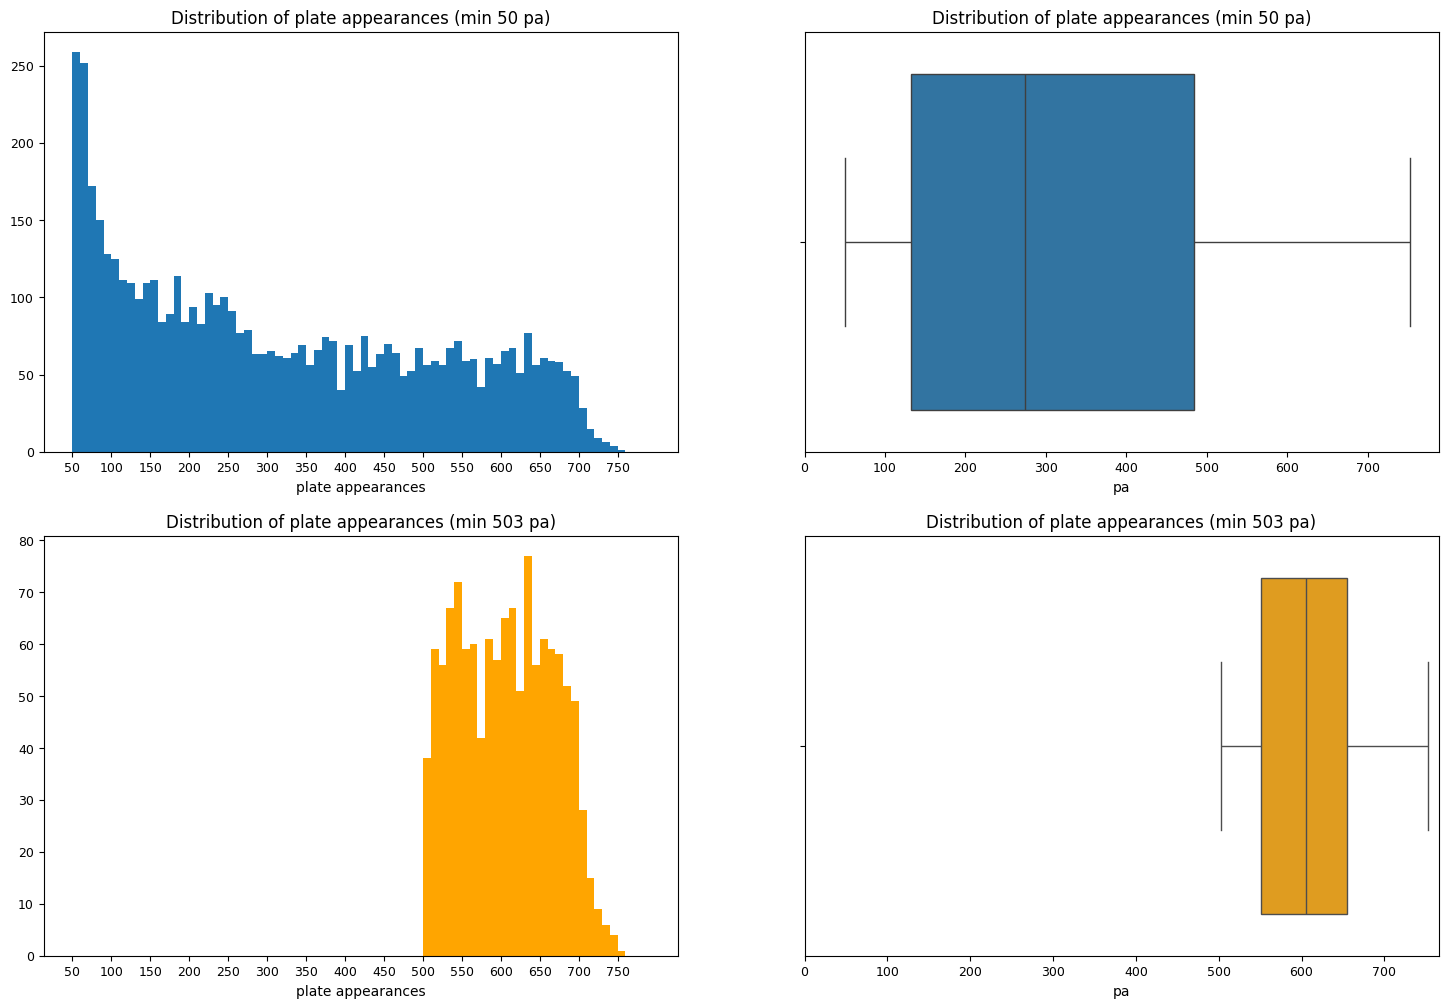

In [206]:
# Set figure and axes
fig, ax = plt.subplots(2, 2, figsize=(18,12))

# Create hist of pa's for all data
ax[0][0].hist(df['pa'], bins=range(50, 800, 10))
ax[0][0].set_xticks(range(50, 800, 50))
ax[0][0].tick_params(axis='both', which='major', labelsize=9)
ax[0][0].set_title('Distribution of plate appearances (min 50 pa)')
ax[0][0].set_xlabel('plate appearances')

# Create hist of pa's for those above cutoff value
ax[1][0].hist(df_min['pa'], bins=range(50, 800, 10), color='orange')
ax[1][0].set_xticks(range(50, 800, 50))
ax[1][0].tick_params(axis='both', which='major', labelsize=9)
ax[1][0].set_title('Distribution of plate appearances (min 503 pa)')
ax[1][0].set_xlabel('plate appearances')

sns.boxplot(x=df['pa'], ax=ax[0][1])
ax[0][1].set_title('Distribution of plate appearances (min 50 pa)')
ax[0][1].tick_params(axis='both', which='major', labelsize=9)
ax[0][1].set_xticks(range(0, 800, 100))

sns.boxplot(x=df_min['pa'], ax=ax[1][1], color='orange')
ax[1][1].set_title('Distribution of plate appearances (min 503 pa)')
ax[1][1].tick_params(axis='both', which='major', labelsize=9)
ax[1][1].set_xticks(range(0, 800, 100))

plt.show()

After applying the minimum cutoff value, the distribution is much more even. We will create another dataset for minimum plate appearances containing only rows with bat tracking metrics as well.

In [153]:
df_tracking_min = df_tracking[df_tracking['pa'] >= pa_cutoff]
print(df_tracking[['pa', 'batting_avg', 'home_run', 'slg_percent']].describe())
print(df_tracking_min[['pa', 'batting_avg', 'home_run', 'slg_percent']].describe())

                pa  batting_avg    home_run  slg_percent
count  1030.000000  1030.000000  1030.00000  1030.000000
mean    346.541748     0.236545    10.82233     0.385516
std     195.993013     0.038318     9.58084     0.083411
min      50.000000     0.077000     0.00000     0.129000
25%     168.000000     0.214000     3.00000     0.332000
50%     336.000000     0.239500     8.00000     0.384000
75%     508.000000     0.262000    16.00000     0.441000
max     753.000000     0.380000    58.00000     0.717000
               pa  batting_avg    home_run  slg_percent
count  262.000000   262.000000  262.000000   262.000000
mean   610.793893     0.259958   21.751908     0.440195
std     62.255526     0.025313    9.348279     0.061175
min    503.000000     0.196000    1.000000     0.296000
25%    556.000000     0.244250   15.000000     0.399000
50%    614.000000     0.258500   21.000000     0.436000
75%    657.000000     0.275000   26.000000     0.469750
max    753.000000     0.354000   58.000